In [1]:
import torch
import numpy
import matplotlib.pyplot as plt
from sklearn import datasets

import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = datasets.load_boston()
X = torch.tensor(data['data'], dtype=torch.float32)
y = torch.tensor(data['target'], dtype=torch.float32)
N, F = X.shape

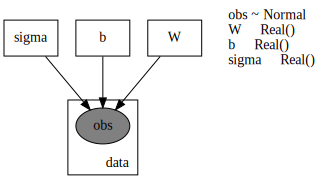

In [4]:
class FrequentistModel(pyro.nn.PyroModule):
    
    def __init__(self):
        super().__init__()
        self.W = pyro.nn.PyroParam(torch.randn(F))
        self.b = pyro.nn.PyroParam(torch.ones(1))
        self.sigma = pyro.nn.PyroParam(torch.ones(1), constraint=constraints.positive)

    def forward(self, X, y=None):
        mean = X @ self.W + self.b

        with pyro.plate("data", len(X)):
            return pyro.sample("obs", dist.Normal(mean, self.sigma), obs=y)

model = FrequentistModel()
pyro.render_model(model, model_args=(X, y), render_distributions=True, render_params=True)

In [5]:
for i in range(3):
    print(model(X)[:5])

tensor([125.9818,  99.4636,  99.5798,  87.1176,  87.8041],
       grad_fn=<SliceBackward0>)
tensor([127.5330,  98.7247,  98.7665,  87.9411,  90.5954],
       grad_fn=<SliceBackward0>)
tensor([127.7760,  98.8845,  99.7804,  88.6126,  88.7049],
       grad_fn=<SliceBackward0>)


In [6]:
dist.Normal(0, 1).expand([F]).sample()

tensor([ 0.3219, -0.7625,  0.2944, -1.2698, -0.4099, -1.3396,  0.6235, -1.5901,
         0.1203, -1.3984, -1.5096,  0.7529, -0.7252])

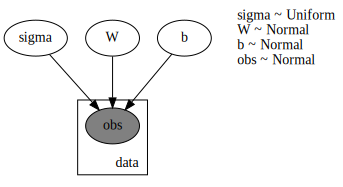

In [7]:
class BayesianModel(pyro.nn.PyroModule):
    
    def __init__(self):
        super().__init__()
        self.W = pyro.nn.PyroSample(dist.Normal(0, 10).expand([F]).to_event(1))
        self.b = pyro.nn.PyroSample(dist.Normal(20, 10))
        self.sigma = pyro.nn.PyroSample(dist.Uniform(0, 10))

    def forward(self, X, y=None):
        sigma = self.sigma   
        mean = X @ self.W + self.b
        
        with pyro.plate("data", N):
            return pyro.sample("obs", dist.Normal(mean, sigma), obs=y)

model = BayesianModel()
pyro.render_model(model, model_args=(X, y), render_distributions=True, render_params=True)

In [8]:
guide = pyro.infer.autoguide.AutoMultivariateNormal(model)

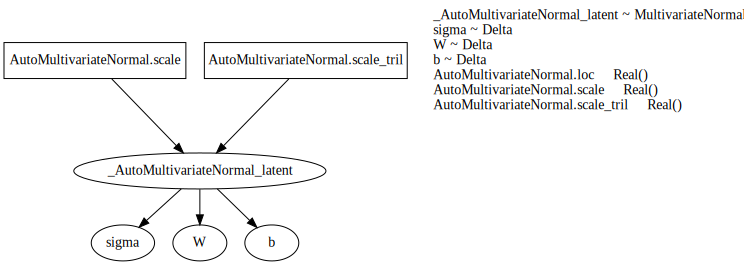

In [9]:
pyro.render_model(guide, model_args=(X, y), render_distributions=True, render_params=True)

In [10]:
guide = pyro.infer.autoguide.AutoMultivariateNormal(model)
adam = pyro.optim.Adam({"lr": 0.02})  
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, guide, adam, elbo)

losses = []
for i in range(10_000):
    loss = svi.step(X, y)
    losses.append(loss)

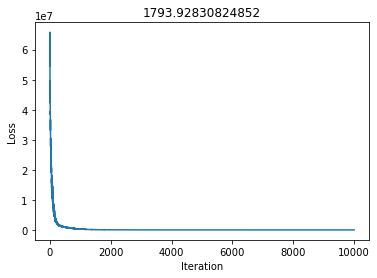

In [11]:
plt.plot(losses)
plt.title(losses[-1])
plt.xlabel('Iteration')
plt.ylabel('Loss');

In [12]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

W [-0.4589224  -1.5169781  -0.7142468   1.2214121   0.4623501  -0.3703135
 -0.4151297  -0.13848422  0.6134994   0.9825258   0.17020313 -0.29490817
  1.5117623 ]
b [1.]
sigma [1.]
AutoMultivariateNormal.loc [ 2.5302367e+00 -7.5996071e-02  5.7630394e-02  1.6922089e-01
  2.9558020e+00  5.7764846e-01  2.5540109e+00  4.4557247e-02
 -3.0125529e-02  4.1698527e-01 -2.4588505e-02 -1.4105776e-01
  4.6085017e-03 -7.5021940e-01  1.6225012e+01]
AutoMultivariateNormal.scale [0.09089936 0.06212966 0.02665913 0.08755858 1.5255352  2.0166163
 0.18321493 0.03909633 0.19392735 0.0629295  0.014659   0.13048191
 0.01841615 0.0746787  0.8909075 ]
AutoMultivariateNormal.scale_tril [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-4.30513546e-02  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 

In [13]:
with pyro.plate('samples', 1_000, dim=-1):
    samples = guide(X)

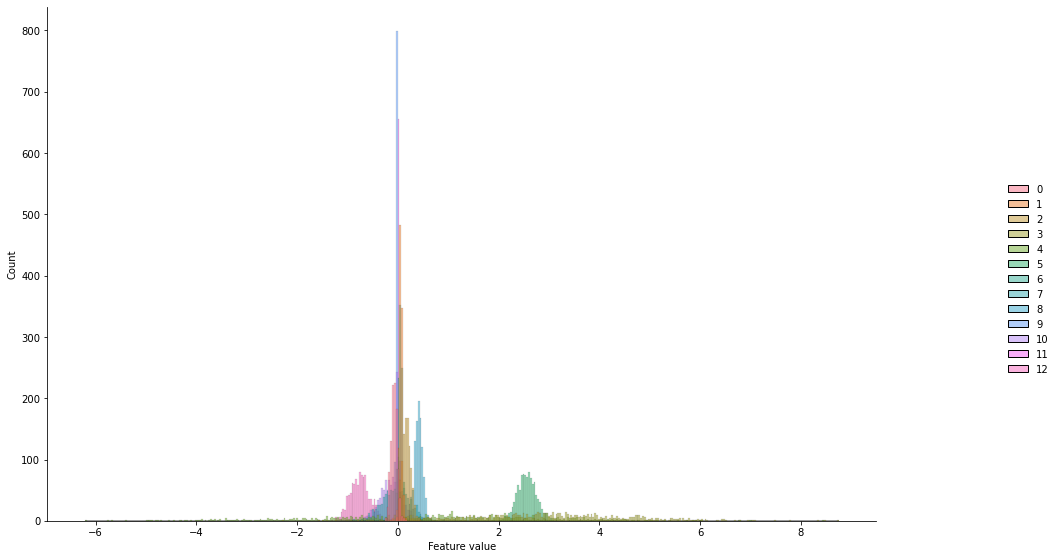

In [14]:
import seaborn as sns
g = sns.displot(samples['W'].detach().numpy())
g.fig.set_figheight(8)
g.fig.set_figwidth(16)
plt.xlabel('Feature value');

In [15]:
predictive = pyro.infer.Predictive(model, guide=guide, num_samples=1_000)
svi_samples = predictive(X)
svi_y = svi_samples["obs"]

In [16]:
svi_y.shape

torch.Size([1000, 506])

In [17]:
# model.eval()
# torch.jit.trace(model, X)

In [18]:
# ws = []
# for i in range(10000):
#     ws.append(model.W)

In [19]:
# print(sum(ws) / len(ws))

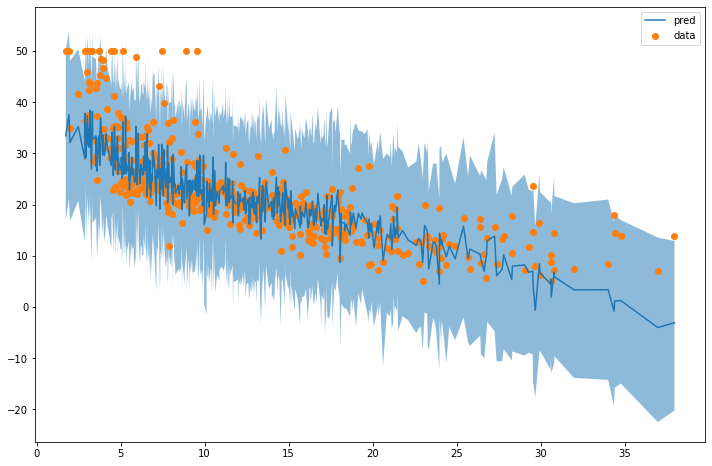

In [20]:
import pandas as pd
preds = pd.DataFrame({
    'X': X[:, -1],
    'y_mean': svi_y.mean(0).detach().cpu().numpy(),
    'y_perc_5': svi_y.kthvalue(int(len(svi_y) * 0.05), dim=0)[0].detach().numpy(),
    'y_perc_95': svi_y.kthvalue(int(len(svi_y) * 0.95), dim=0)[0].detach().numpy(),
    'true_y': y,
})
preds = preds.sort_values('X')

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(preds['X'], preds['y_mean'], label='pred')
ax.fill_between(preds['X'], preds['y_perc_5'], preds['y_perc_95'], alpha=0.5)
ax.scatter(preds['X'], preds['true_y'], label='data')
ax.legend();

In [21]:
X.shape

torch.Size([506, 13])

In [22]:
svi_y.shape

torch.Size([1000, 506])

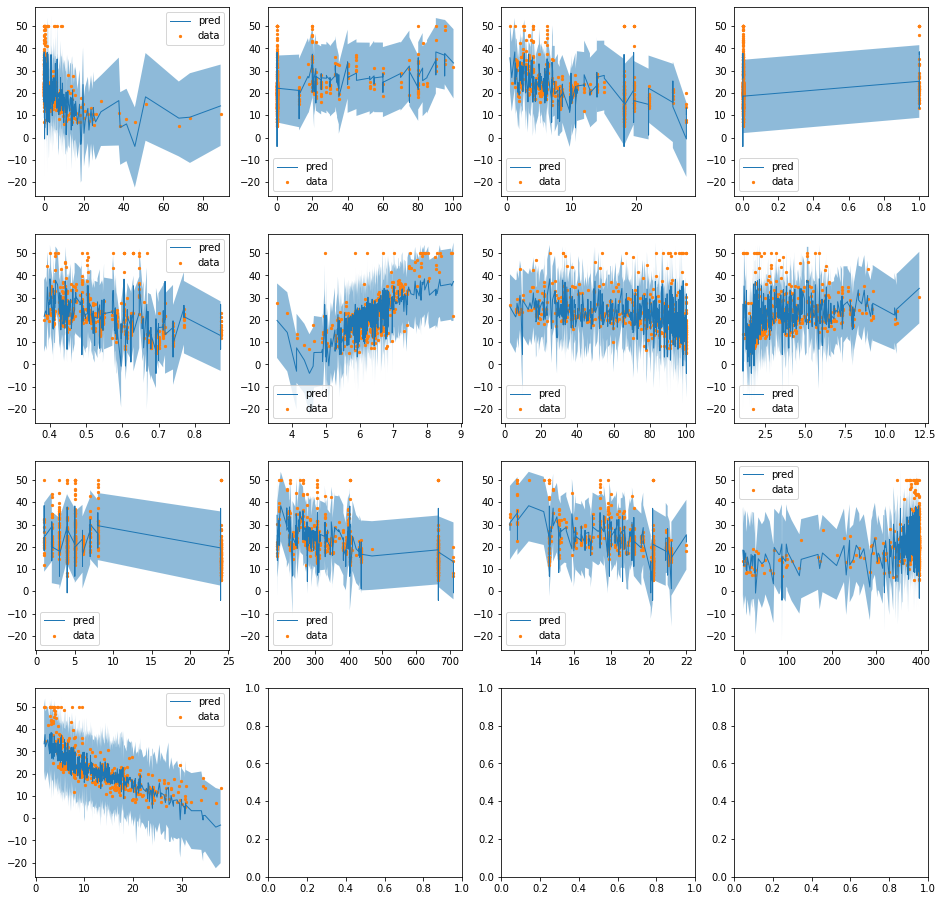

In [23]:
import pandas as pd

fig, axes = plt.subplots(4, 4, figsize=(16,16))
for i in range(F):
    preds = pd.DataFrame({
        'X': X[:, i],
        'y_mean': svi_y.mean(0).detach().cpu().numpy(),
        'y_perc_5': svi_y.kthvalue(int(len(svi_y) * 0.05), dim=0)[0].detach().numpy(),
        'y_perc_95': svi_y.kthvalue(int(len(svi_y) * 0.95), dim=0)[0].detach().numpy(),
        'true_y': y,
    })
    preds = preds.sort_values('X')

    ax = axes[i // 4][i % 4]
    ax.plot(preds['X'], preds['y_mean'], linewidth=1, label='pred')
    ax.fill_between(preds['X'], preds['y_perc_5'], preds['y_perc_95'], alpha=0.5)
    ax.scatter(preds['X'], preds['true_y'], s=5, label='data')
    ax.legend();